In [1]:
from heuristic.trainNetwork import TrainNetwork
from pydantic import BaseModel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from typing import List, Dict, Optional
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output

# Heuristic End to End Search Helper Function Test

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Tabu Search

In [3]:
class Solution(BaseModel):
    solution: List[str]
    distance: int
    
class TabuSearch:
    def __init__(self,graph:TrainNetwork,data:List[str],startVerticesID:str,endVerticesID:str):
        self.graph = graph
        self.data = [d for d in data if d !=startVerticesID and d!=endVerticesID ]
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        self.distanceGraph = None
        
    def buildNeighborDistanceGraph(self):
        try:
            if(self.distanceGraph is None):
                if(self.startVerticesID!=self.endVerticesID):
                    data = [self.startVerticesID] + [d for d in self.data if d !=self.startVerticesID and d!=self.endVerticesID ] + [self.endVerticesID]
                else:
                     data = [self.startVerticesID] + [d for d in self.data if d !=self.startVerticesID and d!=self.endVerticesID ] 
                self.distanceGraph = {}
                for loc1 in data:
                    if self.distanceGraph.get(loc1) is None :self.distanceGraph[loc1] ={} 
                    for loc2 in data:
                        if self.distanceGraph.get(loc1).get(loc2) is None : self.distanceGraph[loc1][loc2]={} 
                        if loc1 == loc2: 
                            self.distanceGraph[loc1][loc2] = 0
                        else:
                            travel = self.graph.breadthFirstSearch(loc1,loc2)
                            if(travel.get("err")): raise Exception(travel.get("err"))
                            distance = len(travel.get("res").get("path"))
                            self.distanceGraph[loc1][loc2] = distance
                
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ...error occured at TabuSearch.getNeighborDistance()"
            
        
    def generateInitialSolution(self):
        try:
            soln = []
            dataList = [d for d in self.data if d!=self.startVerticesID and d!=self.endVerticesID ]
            start,end = self.startVerticesID, self.endVerticesID
            
            fromID = start
            distance = 0
            while len(dataList)>0:
                stack = []
                for toID in dataList:
                    stack.append({"toID":toID, "distance":self.distanceGraph[fromID][toID]})
                stack.sort(key=lambda doc : doc["distance"])
                distance +=  stack[0]["distance"]
                soln.append(stack[0]["toID"])
                dataList = [d for d in dataList if d != stack[0]["toID"] ]
                    
            distance += self.distanceGraph[self.data[len(self.data)-1]][end]
            
            soln = soln
            return Solution(**{"solution":soln,"distance":distance}),None
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ...error occured at TabuSearch.generateInitialSolution()"
       
    def getSolutionNeighbor(self,proposed_soln:Solution):
        try:
            neighbours = []
            neighbours_solution = []
            for i in range(len(proposed_soln.solution)):
                for j in range((i + 1), len(proposed_soln.solution)):
                    neighbour = proposed_soln.solution.copy()
                    neighbour[i],neighbour[j] = neighbour[j],neighbour[i]
                    neighbours_solution.append(neighbour)
            
            for soln in neighbours_solution:
                distance = sum([ self.distanceGraph[soln[i]][soln[i+1]] for i in range(len(proposed_soln.solution)-1)])
                distance += self.distanceGraph[self.startVerticesID][soln[0]]
                distance += self.distanceGraph[soln[len(soln)-1]][self.endVerticesID ]
                neighbours.append(Solution(**{"solution":soln,"distance":distance}))
                
                    
                               
            return neighbours, None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ...error occured at TabuSearch.getSolutionNeighbor()"
            
        
    def Train(self,iteration:int,tabu_list_size:int):
        try:
            # Initialization
            buildDistGraphErr = self.buildNeighborDistanceGraph()
            if buildDistGraphErr is not None : raise Exception(buildDistGraphErr)
                         
            distance_record = []
            iteration_record = []
            tabuList:List[Solution] = []
            proposed_soln, init_soln_err = self.generateInitialSolution()
            if(init_soln_err is not None): raise init_soln_err
            best_soln = proposed_soln
            global_best_soln = proposed_soln
            tabuList.append(proposed_soln)
            
            # iteration
            for i in range(iteration):
                               
                neighbors,getSolnError = self.getSolutionNeighbor(proposed_soln)
                if(getSolnError is not None) : raise Exception(getSolnError)
                
                tabu_list_solution = [soln.solution for soln in tabuList]
                neighbors = [n for n in neighbors if n.solution not in tabu_list_solution]
                for neighbor in neighbors:
                    if neighbor.solution not in tabu_list_solution:
                            if neighbor.distance < best_soln.distance: best_soln = neighbor
 
                if best_soln is None: break
        
                #reporting
                distance_record.append(best_soln.distance)
                iteration_record.append(i)
                
                #plot graph
                clear_output(wait=True)
                plt.xlabel('iteration')
                plt.ylabel('number of station used')
                plt.plot(iteration_record, distance_record)
                plt.show()
           
                if proposed_soln != best_soln:
                    proposed_soln = best_soln
                else:
                    candidates = [n for n in neighbors if n.solution not in tabu_list_solution]
                    if(len(candidates)==0): continue
                    proposed_soln = candidates[int(np.floor(np.random.rand()*len(candidates)))]
                        
                                   
                if best_soln.solution not in tabu_list_solution: tabuList.append(best_soln)
                if len(tabuList) > tabu_list_size: tabuList.pop(0)
 
                global_best_soln = best_soln if global_best_soln.distance > best_soln.distance else global_best_soln
              
            for doc in tabuList:
                doc.solution = [self.startVerticesID] + doc.solution + [self.endVerticesID]
            allSoln = tabuList
            allSoln.sort(key=lambda record: record.distance)
                               
            return allSoln,None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return f"{str(error)} ...error occured at TabuSearch.Train()"
        

# Random Generate Test Data

In [4]:
stationIDs = trainNetwork.getRandomVerticesID(10).get("res")
# stationIDs = ['AG16','KJ35','AG11','PY21','AG1','PY27','PY22','KG33','KJ5','KJ9','SP8','KJ19','AG6','KG17','AG7','KG34','PY37','SP4','SP14','KJ6']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,PY19,Raja Uda,"{'lat': '3.16783', 'lon': '101.71104'}"
1,SP14,Bandar Tun Razak,"{'lat': '3.089669', 'lon': '101.7125175'}"
2,SP16,Sungai Besi,"{'lat': '3.06394', 'lon': '101.70801'}"
3,KJ8,Damai,"{'lat': '3.1644056', 'lon': '101.7244889'}"
4,PY01,Kwasa Damansara,"{'lat': '3.1763838', 'lon': '101.572348'}"
5,SP18,Sri Petaling,"{'lat': '3.06144', 'lon': '101.68707'}"
6,KJ19,Universiti,"{'lat': '3.1145746', 'lon': '101.6617999'}"
7,SP27,Bandar Puteri,"{'lat': '3.0170271', 'lon': '101.6128574'}"
8,PY14,Kentonmen,"{'lat': '3.19549', 'lon': '101.67963'}"
9,KJ10,KLCC,"{'lat': '3.15908', 'lon': '101.71288'}"


# Model Fitting

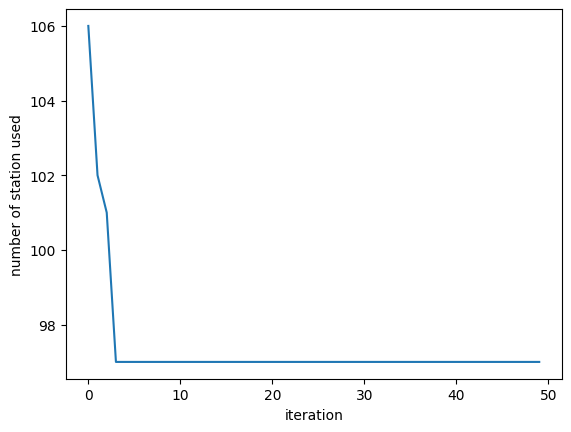

In [5]:
start = stationIDs[0]
end = stationIDs[len(stationIDs)-1]
iteration = 50
tabu_list_size = 10 #len(stationIDs)

tabu_search = TabuSearch(trainNetwork,stationIDs,start,end)
solution,trainErr = tabu_search.Train(iteration,tabu_list_size)

# Tabu List

In [6]:
result = [ dict(s) for s in solution ]
pd.DataFrame(result)

,solution,distance
0,"[PY19, KJ8, PY14, PY01, KJ19, SP14, SP18, SP27...",97
1,"[PY19, KJ8, PY14, PY01, KJ19, SP27, SP18, SP14...",101
2,"[PY19, KJ8, PY14, PY01, SP16, SP27, SP18, SP14...",102
3,"[PY19, KJ8, PY14, SP14, SP16, SP27, SP18, PY01...",106
4,"[PY19, KJ8, PY14, SP14, SP16, KJ19, SP18, PY01...",108


# Best Result

In [7]:
soln = [trainNetwork.vertices.get(stationID) for stationID in result[0].get("solution")]
pd.DataFrame(soln)

,id,stationName,coordinate
0,PY19,Raja Uda,"{'lat': '3.16783', 'lon': '101.71104'}"
1,KJ8,Damai,"{'lat': '3.1644056', 'lon': '101.7244889'}"
2,PY14,Kentonmen,"{'lat': '3.19549', 'lon': '101.67963'}"
3,PY01,Kwasa Damansara,"{'lat': '3.1763838', 'lon': '101.572348'}"
4,KJ19,Universiti,"{'lat': '3.1145746', 'lon': '101.6617999'}"
5,SP14,Bandar Tun Razak,"{'lat': '3.089669', 'lon': '101.7125175'}"
6,SP18,Sri Petaling,"{'lat': '3.06144', 'lon': '101.68707'}"
7,SP27,Bandar Puteri,"{'lat': '3.0170271', 'lon': '101.6128574'}"
8,SP16,Sungai Besi,"{'lat': '3.06394', 'lon': '101.70801'}"
9,KJ10,KLCC,"{'lat': '3.15908', 'lon': '101.71288'}"


# Map Visualization

In [8]:
stations = result[0].get("solution")
paths = []
for i in range(len(stations)):
    if i > 0:
        from_id = stations[i-1]
        to_id = stations[i]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

# print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
    if len(allPath)>0: path.pop(0)
    allPath += path

In [9]:
pathData = [trainNetwork.vertices[stationID] for stationID in allPath]
locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
    ).add_to(Map)
    
     
Map